In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Jonathan R. Matos
# PearlX TakeHome
# October 22 2023
#
# Goal - to clean the data, discover if there are any relationships between weather and solar pv production.
#
# Initial thoughts - Radiation is the most important. I should convert sunshine in minutes to cloud coverage. The panels only turn
#  on when radiation is above 100.
#
# Question 1. Does Windspeed, Temperature, and Humidity the night before effect Radiation, Cloud Coverage, and Production the next day. Medium
# Question 2. Can Temperature, Humidity, Radiation, and Cloud Coverage be used to predict Production for the next day. Little
# Question 3. Can Temperature, Humidity, and Cloud Coverage predict Radiation and Production 1 day, 1 week, 1 month into the future. None
# Question 4. Can these weather and production variables be used to build a revenue model based off weather. None
#
# What I should have done differently: Ask where is this system located so I can get better information on sunrise sunet.
#  Connected to a weather API to get more data. Use a Julian clock for sunrise sunset. 

In [3]:
# Load the dataset
file_path = 'WeatherPVData.csv'
df = pd.read_csv(file_path)

In [4]:
# Show the first few rows to understand the structure and contents
df.head()

,Date-Hour,WindSpeed,Sunshine in minutes,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


In [5]:
# Parse 'Date-Hour' to datetime format and separate it into 'Date' and 'Hour' columns
df['Date-Hour'] = pd.to_datetime(df['Date-Hour'], format='%d.%m.%Y-%H:%M')
df['Date'] = df['Date-Hour'].dt.date
df['Hour'] = df['Date-Hour'].dt.hour

# Drop the original 'Date-Hour' column as we've separated it
df.drop('Date-Hour', axis=1, inplace=True)

# Show the first few rows to confirm the changes
df.head()

,WindSpeed,Sunshine in minutes,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Date,Hour
0,0.6,0,1003.8,-7.4,0.1,97,0.0,2017-01-01,0
1,1.7,0,1003.5,-7.4,-0.2,98,0.0,2017-01-01,1
2,0.6,0,1003.4,-6.7,-1.2,99,0.0,2017-01-01,2
3,2.4,0,1003.3,-7.2,-1.3,99,0.0,2017-01-01,3
4,4.0,0,1003.1,-6.3,3.6,67,0.0,2017-01-01,4


In [6]:
# Convert AirTemperature from Celsius to Fahrenheit
df['AirTemperature'] = (df['AirTemperature'] * 9/5) + 32
# Round AirTemperature to the nearest whole number
df['AirTemperature'] = df['AirTemperature'].round(1).astype(int)

# Convert WindSpeed from meters per second to miles per hour
df['WindSpeed'] = df['WindSpeed'] * 2.23694
# Round the WindSpeed to the nearest 1st decimal place
df['WindSpeed'] = df['WindSpeed'].round(1)

# Round SystemProduction to the nearest whole number
df['SystemProduction'] = df['SystemProduction'].round(1).astype(int)

# Round AirPressure to the nearest whole number
df['AirPressure'] = df['AirPressure'].round(1).astype(int)

# Convert 'Sunshine Min' to 'Cloud Coverage' for each hour
# Since each hour has 60 minutes, the cloud coverage can be calculated as (60 - Sunshine Min)
df['Cloud Coverage Minutes'] = 60 - df['Sunshine in minutes']

# Drop the 'Sunshine in minutes' column
df.drop('Sunshine in minutes', axis=1, inplace=True)

# Show the first few rows after the conversion
df.head()

,WindSpeed,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Date,Hour,Cloud Coverage Minutes
0,1.3,1003,-7.4,32,97,0,2017-01-01,0,60
1,3.8,1003,-7.4,31,98,0,2017-01-01,1,60
2,1.3,1003,-6.7,29,99,0,2017-01-01,2,60
3,5.4,1003,-7.2,29,99,0,2017-01-01,3,60
4,8.9,1003,-6.3,38,67,0,2017-01-01,4,60


In [7]:
# To focus on the instances where the radiation value changes sign, we first create a column that captures this sign change.
# We will look for rows where the sign of 'Radiation W/sqm' changes compared to the previous row.
# This can be used to create a more accurate model.

# Create a new column for the sign of 'Radiation'
df['Radiation_Sign'] = np.sign(df['Radiation'])

# Identify where the sign changes
df['Radiation_Sign_Change'] = df['Radiation_Sign'].diff().ne(0)

# Filter the dataset to only include instances where the sign changes, as these indicate sunrise (negative to positive)
# and sunset (positive to negative)
df_radiation_sign_change = df[df['Radiation_Sign_Change']]

# Group by 'Date' and find the minimum hour for sunrise and the maximum hour for sunset
df_sunrise_sign_change = df_radiation_sign_change.groupby('Date')['Hour'].min().reset_index()
df_sunset_sign_change = df_radiation_sign_change.groupby('Date')['Hour'].max().reset_index()

# Calculate the average sunrise and sunset time for each day
average_sunrise_sign_change_daily = df_sunrise_sign_change.groupby('Date')['Hour'].mean().reset_index()
average_sunset_sign_change_daily = df_sunset_sign_change.groupby('Date')['Hour'].mean().reset_index()

average_sunrise_sign_change_daily, average_sunset_sign_change_daily

(           Date  Hour
 0    2017-01-01   0.0
 1    2017-01-02  10.0
 2    2017-01-03  11.0
 3    2017-01-04  10.0
 4    2017-01-05  10.0
 ..          ...   ...
 360  2017-12-27  10.0
 361  2017-12-28  11.0
 362  2017-12-29  11.0
 363  2017-12-30  11.0
 364  2017-12-31  11.0
 
 [365 rows x 2 columns],
            Date  Hour
 0    2017-01-01  16.0
 1    2017-01-02  17.0
 2    2017-01-03  16.0
 3    2017-01-04  16.0
 4    2017-01-05  17.0
 ..          ...   ...
 360  2017-12-27  16.0
 361  2017-12-28  15.0
 362  2017-12-29  16.0
 363  2017-12-30  16.0
 364  2017-12-31  16.0
 
 [365 rows x 2 columns])

In [8]:
# Create a new DataFrame with the sunrise and sunset times
df_sunrise_sunset = pd.merge(
    df_sunrise_sign_change, df_sunset_sign_change, how='inner', on='Date'
)

# Rename the columns to 'Sunrise' and 'Sunset'
df_sunrise_sunset.rename(columns={'Hour_x': 'Sunrise', 'Hour_y': 'Sunset'}, inplace=True)

# Display the DataFrame
df_sunrise_sunset

,Date,Sunrise,Sunset
0,2017-01-01,0,16
1,2017-01-02,10,17
2,2017-01-03,11,16
3,2017-01-04,10,16
4,2017-01-05,10,17
...,...,...,...
360,2017-12-27,10,16
361,2017-12-28,11,15
362,2017-12-29,11,16
363,2017-12-30,11,16


In [9]:
output_filename = 'SunriseSunset.csv'
output_path = output_filename
df_sunrise_sunset.to_csv(output_path, index=False)

In [10]:
# Rename the columns as specified
column_name_mapping = {
    'WindSpeed': 'WindSpeed MPH',
    'AirPressure': 'AirPressure Millibar',
    'Radiation': 'Radiation W/sqm',
    'AirTemperature': 'AirTemperature F',
    'RelativeAirHumidity': 'RelativeAirHumidity %',
    'SystemProduction': 'SystemProduction Wh'
}

df.rename(columns=column_name_mapping, inplace=True)

# Show the first few rows to confirm the changes
df.head(25)

,WindSpeed MPH,AirPressure Millibar,Radiation W/sqm,AirTemperature F,RelativeAirHumidity %,SystemProduction Wh,Date,Hour,Cloud Coverage Minutes,Radiation_Sign,Radiation_Sign_Change
0,1.3,1003,-7.4,32,97,0,2017-01-01,0,60,-1.0,True
1,3.8,1003,-7.4,31,98,0,2017-01-01,1,60,-1.0,False
2,1.3,1003,-6.7,29,99,0,2017-01-01,2,60,-1.0,False
3,5.4,1003,-7.2,29,99,0,2017-01-01,3,60,-1.0,False
4,8.9,1003,-6.3,38,67,0,2017-01-01,4,60,-1.0,False
5,3.1,1003,-6.8,34,74,0,2017-01-01,5,60,-1.0,False
6,3.1,1003,-7.0,32,79,0,2017-01-01,6,60,-1.0,False
7,2.9,1003,-7.0,30,81,0,2017-01-01,7,60,-1.0,False
8,1.3,1004,-6.6,30,77,0,2017-01-01,8,60,-1.0,False
9,1.3,1004,-6.5,28,81,0,2017-01-01,9,60,-1.0,False


In [11]:
# Check for missing values in the dataset
missing_values_count = df.isnull().sum()
missing_values_count

WindSpeed MPH             0
AirPressure Millibar      0
Radiation W/sqm           0
AirTemperature F          0
RelativeAirHumidity %     0
SystemProduction Wh       0
Date                      0
Hour                      0
Cloud Coverage Minutes    0
Radiation_Sign            0
Radiation_Sign_Change     0
dtype: int64

In [12]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

duplicate_rows

0

In [14]:
# Revert the 'Date' column to Pandas datetime64[ns] format
df['Date'] = pd.to_datetime(df['Date'])


# I want to add a variable to show day or night so I can create more accurate models such as do stuff at night effect the day?
#
# Reset the 'Is_Daytime' column to 0
df['Is_Daytime'] = 0  # Set to 0 (False) by default

# I added seasons to this as they can be used in time evaluation.
# 
# Define date ranges and corresponding daytime hours along with seasons
date_ranges = [
    (pd.Timestamp('2017-12-01'), pd.Timestamp('2017-12-31'), 7, 17, 'Winter'),
    (pd.Timestamp('2017-01-01'), pd.Timestamp('2017-02-28'), 7, 17, 'Winter'),
    (pd.Timestamp('2017-03-01'), pd.Timestamp('2017-05-31'), 6, 19, 'Spring'),
    (pd.Timestamp('2017-06-01'), pd.Timestamp('2017-08-31'), 5, 20, 'Summer'),
    (pd.Timestamp('2017-09-01'), pd.Timestamp('2017-11-30'), 6, 18, 'Autumn')
]

# Initialize a new column for the seasons
df['Season'] = ''  # Placeholder values

# Loop through each date range to set the "Is_Daytime" and "Season" flags
for start_date, end_date, sunrise_hour, sunset_hour, season in date_ranges:
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    df.loc[mask, 'Is_Daytime'] = ((df['Hour'] >= sunrise_hour) & (df['Hour'] < sunset_hour)).astype(int)  # Cast to int here
    df.loc[mask, 'Season'] = season


# Show the first few rows and the number of missing values and duplicate rows to confirm the changes
df_head = df.head(100)

In [15]:
# Reorder the columns to move 'Date' and 'Hour' and 'Is_Daytime' to the left of 'WindSpeed MPH'
column_order = ['Date', 'Hour', 'Is_Daytime'] + [col for col in df.columns if col not in ['Date', 'Hour', 'Is_Daytime']]
df = df[column_order]

# Show the first few rows to confirm the changes
df.head()

,Date,Hour,Is_Daytime,WindSpeed MPH,AirPressure Millibar,Radiation W/sqm,AirTemperature F,RelativeAirHumidity %,SystemProduction Wh,Cloud Coverage Minutes,Radiation_Sign,Radiation_Sign_Change,Season
0,2017-01-01,0,0,1.3,1003,-7.4,32,97,0,60,-1.0,True,Winter
1,2017-01-01,1,0,3.8,1003,-7.4,31,98,0,60,-1.0,False,Winter
2,2017-01-01,2,0,1.3,1003,-6.7,29,99,0,60,-1.0,False,Winter
3,2017-01-01,3,0,5.4,1003,-7.2,29,99,0,60,-1.0,False,Winter
4,2017-01-01,4,0,8.9,1003,-6.3,38,67,0,60,-1.0,False,Winter


In [16]:
output_filename = 'IsDaytimePVData.csv'
output_path = output_filename
df.to_csv(output_path, index=False)

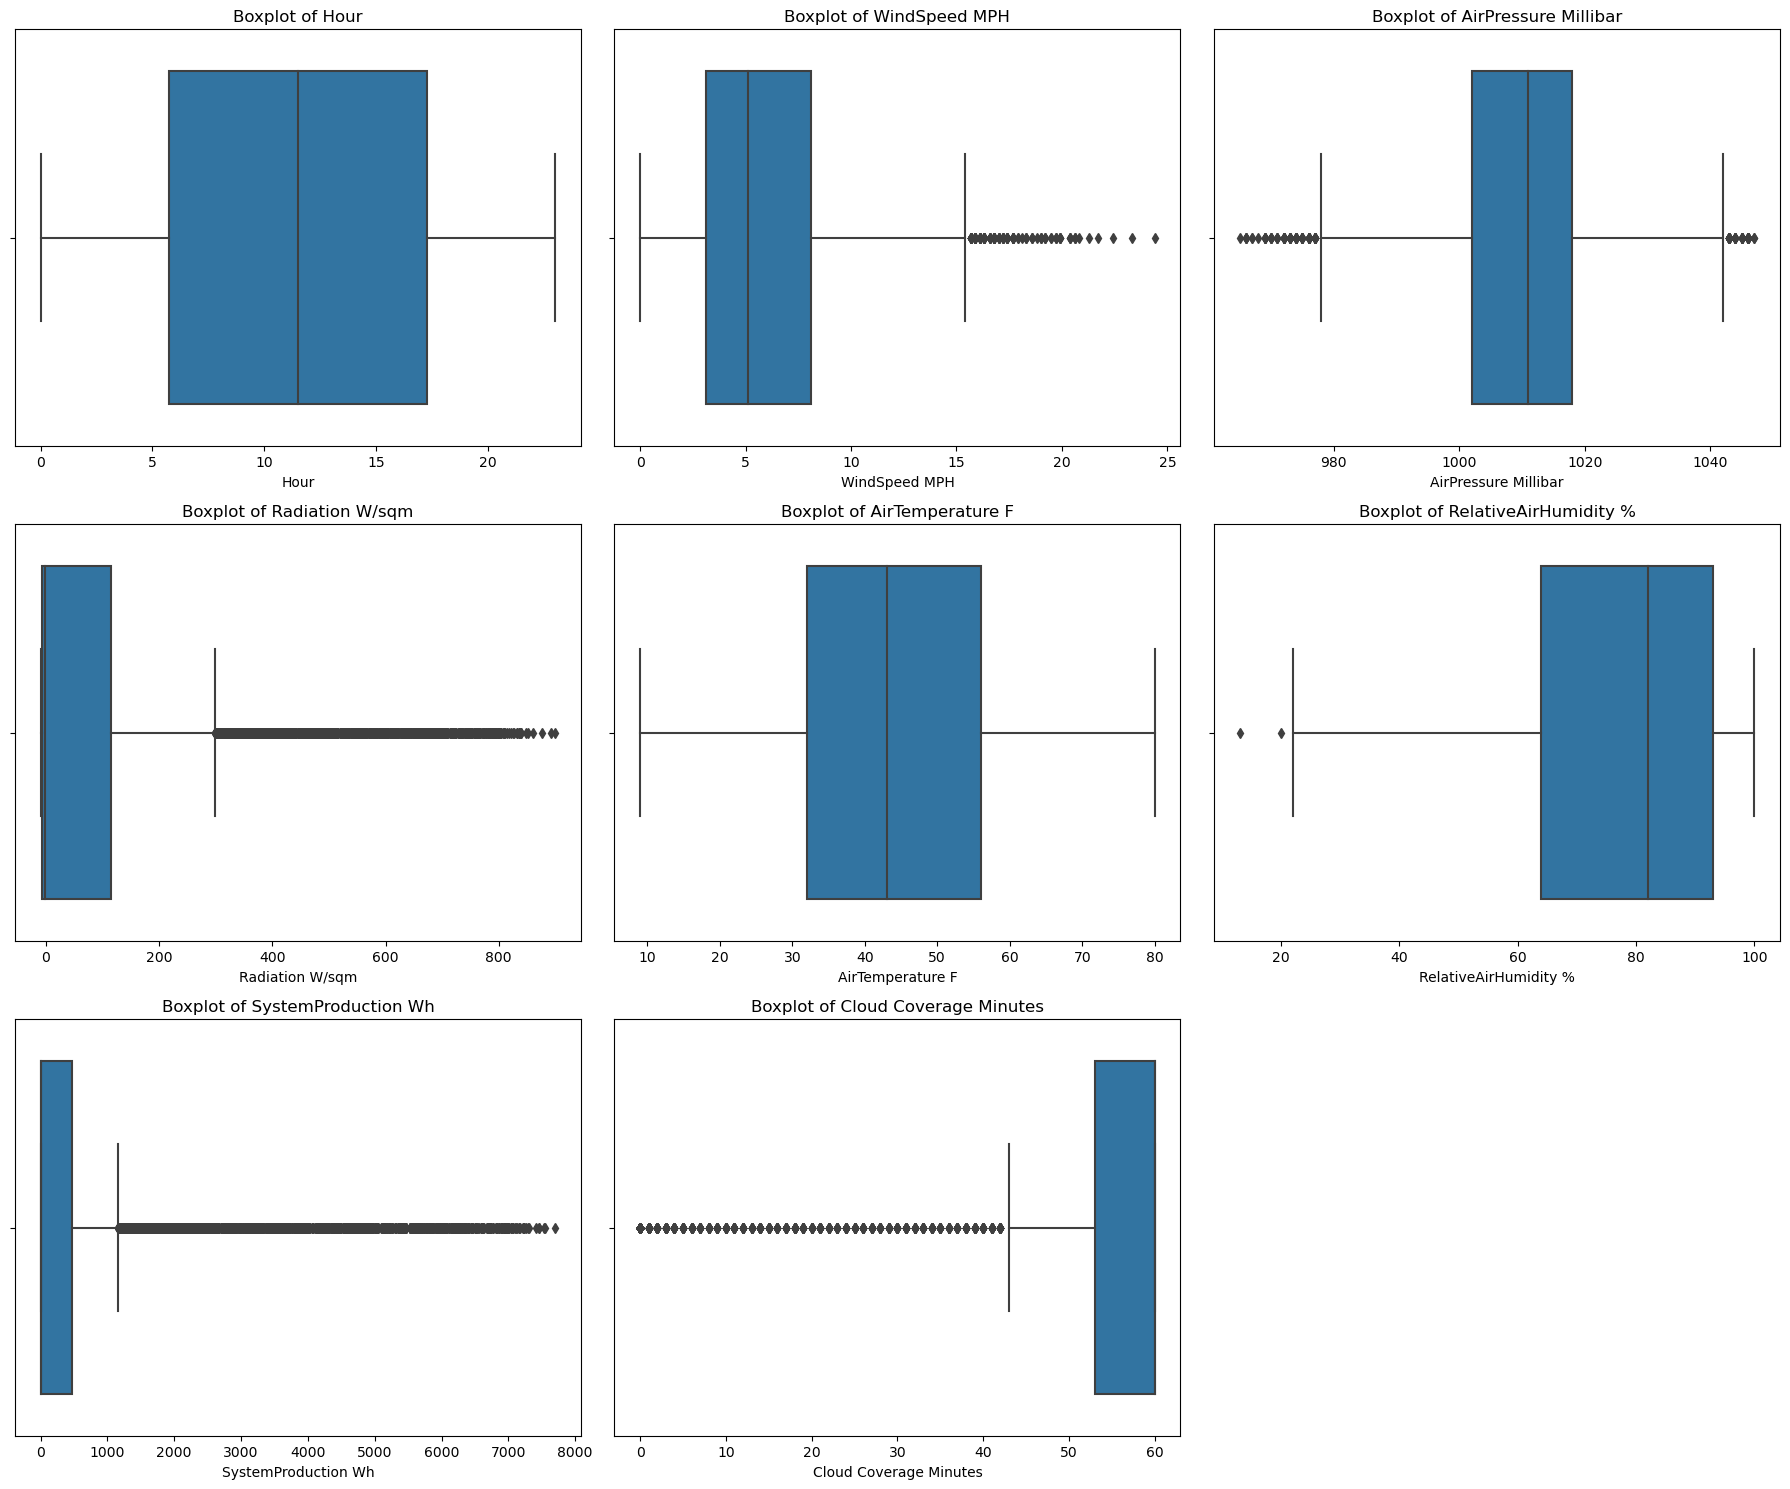

In [19]:
# Select only numeric columns, excluding 'Season_Int', 'Radiation_Sign', and 'Is_Daytime'
numeric_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in ['Season_Int', 'Radiation_Sign', 'Is_Daytime']]

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Calculating the required number of subplots based on the number of numeric columns
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division to get the number of rows

# Setting up the matplotlib figure for Outlier Analysis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))

# Flatten the axes for easier indexing, and remove unused subplots if any
axes = axes.flatten()
for i in range(len(numeric_cols), n_rows * n_cols):
  fig.delaxes(axes[i])

# Looping through each numeric column to plot boxplots for outlier detection
for i, col in enumerate(numeric_cols):
  sns.boxplot(x=df[col], ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [20]:
# I will not remove these outliers as they are reasonable in nature
#

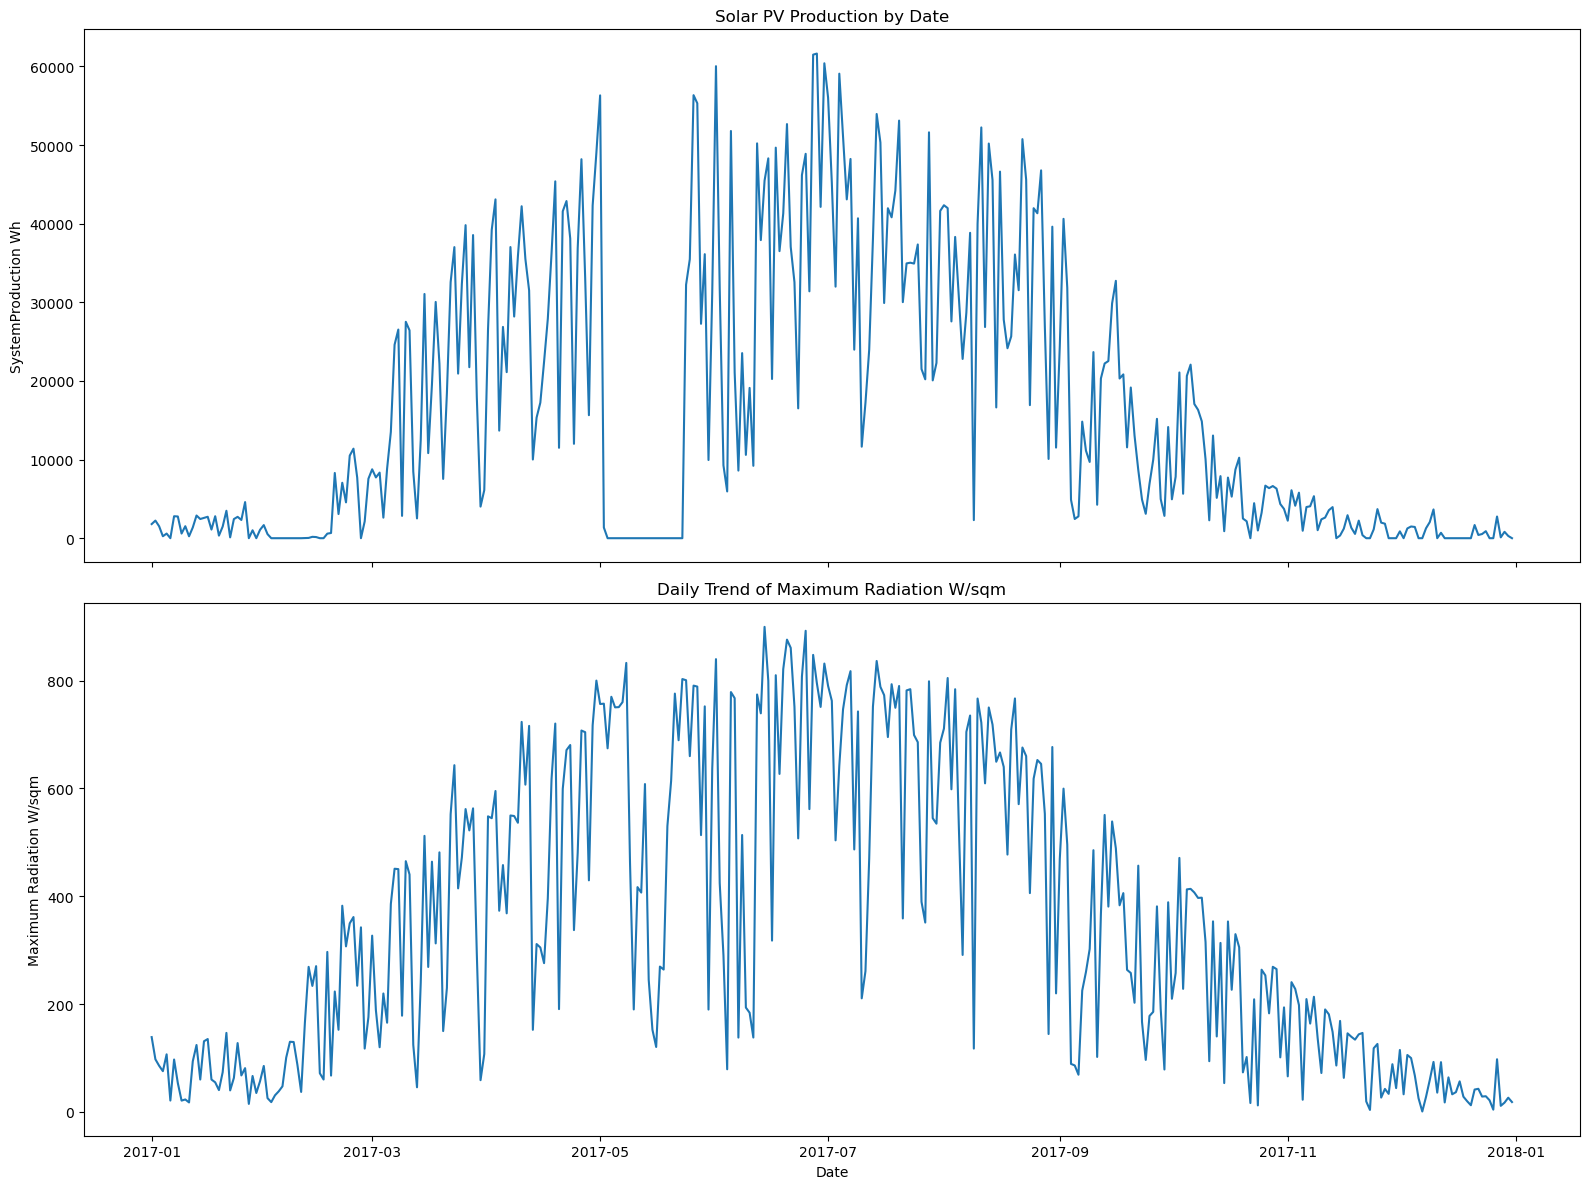

In [21]:
# I already know that radiation is the biggest factor to PVProduction. So I will perform a temporal analysis
# to quickly see if the system was operational for the entire year.

# Aggregate the data by Date
df_aggregated_by_date = df.groupby('Date').agg({
    'SystemProduction Wh': 'sum',
    'Radiation W/sqm': 'max'
}).reset_index()

# Set up the matplotlib figure for Temporal Analysis
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Plotting the solar PV production by Date
sns.lineplot(x='Date', y='SystemProduction Wh', data=df_aggregated_by_date, ax=axes[0])
axes[0].set_title('Solar PV Production by Date')
axes[0].set_ylabel('SystemProduction Wh')

# Plotting the daily trend of maximum Radiation
sns.lineplot(x='Date', y='Radiation W/sqm', data=df_aggregated_by_date, ax=axes[1])
axes[1].set_title('Daily Trend of Maximum Radiation W/sqm')
axes[1].set_ylabel('Maximum Radiation W/sqm')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [22]:
# Looks like there is indeed a couple time periods when the solar system was not operational so i will take out those days.

# Filter the data to find days with 0 production but have over 100 for radiation
filtered_data = df.groupby('Date').agg({
    'SystemProduction Wh': 'sum',
    'Radiation W/sqm': 'max'
}).reset_index()

# Identify days with 0 production and radiation over 100
zero_prod_high_rad_days = filtered_data[(filtered_data['SystemProduction Wh'] == 0) & (filtered_data['Radiation W/sqm'] > 100)]

zero_prod_high_rad_days

,Date,SystemProduction Wh,Radiation W/sqm
36,2017-02-06,0,100.7
37,2017-02-07,0,130.0
38,2017-02-08,0,129.6
56,2017-02-26,0,342.3
122,2017-05-03,0,674.4
123,2017-05-04,0,770.0
124,2017-05-05,0,750.4
125,2017-05-06,0,750.8
126,2017-05-07,0,760.1
127,2017-05-08,0,832.8


In [23]:
# Identify the dates that need to be removed
dates_to_remove = zero_prod_high_rad_days['Date'].tolist()

# Remove these dates from the original DataFrame
df_filtered = df[~df['Date'].isin(dates_to_remove)]

# Show the shape of the original and new DataFrames to confirm the deletion
df.shape, df_filtered.shape

((8760, 13), (8160, 13))

In [24]:
output_filename = 'DownDaysPVData.csv'
output_path = output_filename
df_filtered.to_csv(output_path, index=False)

In [25]:
# Now I will look to see a day before and after to see what hours the system was not operatinal
# during the time periods above and delete those hours. 

# Filter the DataFrame to include only the specified dates
specified_dates = ['2017-05-24', '2017-05-02', '2017-02-05', '2017-02-09', '2017-02-25', '2017-02-27']
df_specified_dates = df[df['Date'].astype(str).isin(specified_dates)]

# Filter further to find rows with Radiation over 100 and 0 solar production
df_filtered_hours = df_specified_dates[(df_specified_dates['Radiation W/sqm'] > 100) & (df_specified_dates['SystemProduction Wh'] == 0)]

# Show the filtered data
df_filtered_hours[['Date', 'Hour', 'Radiation W/sqm', 'SystemProduction Wh']]

,Date,Hour,Radiation W/sqm,SystemProduction Wh
2910,2017-05-02,6,103.2,0
2911,2017-05-02,7,235.2,0
2916,2017-05-02,12,749.8,0
2917,2017-05-02,13,757.2,0
2918,2017-05-02,14,730.2,0
2919,2017-05-02,15,653.4,0
2920,2017-05-02,16,553.1,0
2921,2017-05-02,17,429.7,0
2922,2017-05-02,18,299.6,0
2923,2017-05-02,19,164.1,0


In [26]:
# Identify the index values of the rows to be removed
indices_to_remove = df_filtered_hours.index

# Remove these rows from the filtered DataFrame
df_final_filtered = df_filtered.drop(indices_to_remove, axis=0)

# Show the shape of the filtered and final filtered DataFrames to confirm the deletion
filtered_shape_before = df_filtered.shape
filtered_shape_after = df_final_filtered.shape

filtered_shape_before, filtered_shape_after

((8160, 13), (8142, 13))

In [27]:
output_filename = 'DownHoursDaysPVData.csv'
output_path = output_filename
df_final_filtered.to_csv(output_path,index=False)

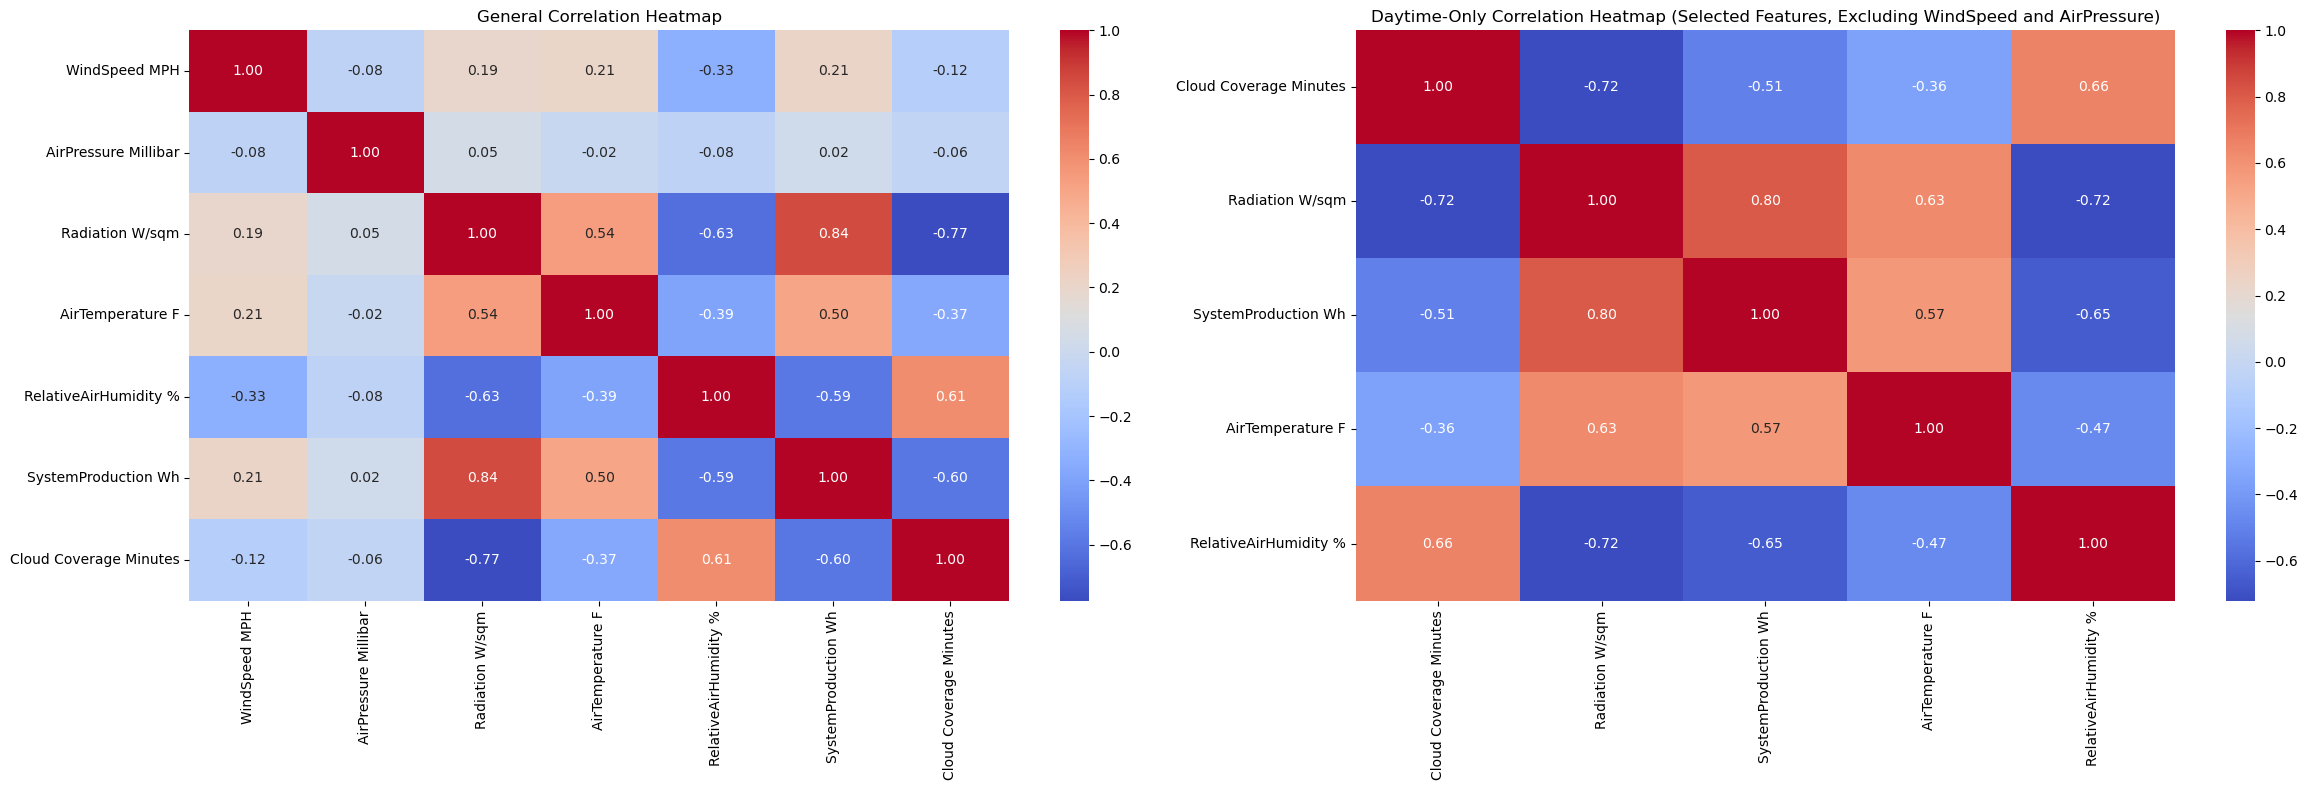

In [30]:
# First I want to see the correlation between all variables during day and night and then only day for the stronger ones


# Check if 'Is_Daytime' exists in df_filtered
if 'Is_Daytime' not in df_filtered.columns:
    print("Error: 'Is_Daytime' column is missing in df_filtered.")
    # Add appropriate logic here to handle the missing column
else:
    # Convert 'Is_Daytime' column to integer type to avoid future errors
    df_filtered.loc[:, 'Is_Daytime'] = df_filtered['Is_Daytime'].astype(int)

# For general correlation
df_corr_general = df_filtered.drop(['Hour', 'Date', 'Is_Daytime', 'Season', 'Radiation_Sign', 'Radiation_Sign_Change'], axis=1)
corr_matrix_general = df_corr_general.corr()

# For daytime-only correlation
df_corr_daytime = df_filtered[df_filtered['Is_Daytime'] == 1].drop(['Hour', 'Date', 'Is_Daytime', 'Season', 'Radiation_Sign', 'Radiation_Sign_Change'], axis=1)
selected_features_daytime = ['Cloud Coverage Minutes', 'Radiation W/sqm', 'SystemProduction Wh', 'AirTemperature F', 'RelativeAirHumidity %']
corr_matrix_daytime_selected = df_corr_daytime[selected_features_daytime].corr()

# Generate combined correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# General Correlation Heatmap
sns.heatmap(corr_matrix_general, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0])
axes[0].set_title('General Correlation Heatmap')

# Daytime-Only Correlation Heatmap with selected features
sns.heatmap(corr_matrix_daytime_selected, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1])
axes[1].set_title('Daytime-Only Correlation Heatmap (Selected Features, Excluding WindSpeed and AirPressure)')

plt.tight_layout()
plt.show()

In [31]:
output_filename = 'DownHoursDaysPVData.csv'
output_path = output_filename
df_final_filtered.to_csv(output_path,index=False)

In [32]:
# Deciding to drop AirPressure as there is no correlation.

# Create a new DataFrame called df_everythingbutair and drop the 'AirPressure Millibar' column
df_everythingbutair = df_filtered.drop('AirPressure Millibar', axis=1)

# Show the first few rows to confirm the column has been dropped
df_everythingbutair.head()

,Date,Hour,Is_Daytime,WindSpeed MPH,Radiation W/sqm,AirTemperature F,RelativeAirHumidity %,SystemProduction Wh,Cloud Coverage Minutes,Radiation_Sign,Radiation_Sign_Change,Season
0,2017-01-01,0,0,1.3,-7.4,32,97,0,60,-1.0,True,Winter
1,2017-01-01,1,0,3.8,-7.4,31,98,0,60,-1.0,False,Winter
2,2017-01-01,2,0,1.3,-6.7,29,99,0,60,-1.0,False,Winter
3,2017-01-01,3,0,5.4,-7.2,29,99,0,60,-1.0,False,Winter
4,2017-01-01,4,0,8.9,-6.3,38,67,0,60,-1.0,False,Winter


In [33]:
output_filename = 'df_everythingbutair.csv'
output_path = output_filename
df_everythingbutair.to_csv(output_path,index=False)

In [34]:
# Question 1
# This is to test if windspeed, airtemperature, and relativeairhumidity at night can be used to predict 
# the cloud coverage, system production, and radiation the next day
#

# Create lagged features for 'WindSpeed MPH', 'AirTemperature F', and 'RelativeAirHumidity %'
lag_features = ['WindSpeed MPH', 'AirTemperature F', 'RelativeAirHumidity %']
df_lagged = df_everythingbutair.copy()

# Creating the lagged features for the night before (assuming night starts at 20:00 or 8 PM)
for feature in lag_features:
    for lag in [20]:
        df_lagged[f"{feature}_lag{lag}"] = df_lagged[feature].shift(lag)

# Drop the rows where lagged features are NaN
df_lagged.dropna(inplace=True)

# Features and target variables
X = df_lagged[[f"{feature}_lag20" for feature in lag_features]]
y = df_lagged[['Cloud Coverage Minutes', 'SystemProduction Wh', 'Radiation W/sqm']]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize and fit the Linear Regression model
linear_regressor = LinearRegression()
linear_model = MultiOutputRegressor(linear_regressor)
linear_model.fit(X_train, y_train)

# Initialize and fit the Gradient Boosting model
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model = MultiOutputRegressor(gb_regressor)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Evaluation
mse_linear = mean_squared_error(y_test, y_pred_linear, multioutput='raw_values')
r2_linear = r2_score(y_test, y_pred_linear, multioutput='raw_values')

mse_gb = mean_squared_error(y_test, y_pred_gb, multioutput='raw_values')
r2_gb = r2_score(y_test, y_pred_gb, multioutput='raw_values')

mse_linear, r2_linear, mse_gb, r2_gb

(array([   250.41219832, 232848.92822123,   4050.49424319]),
 array([ 0.02734617, -1.30218003, -1.17550812]),
 array([   252.04968113, 237050.60506789,   3194.21285363]),
 array([ 0.02098584, -1.34372206, -0.715602  ]))

In [35]:
# The best would be gradient boosting. Its not that well of a predictor but its not bad.

In [36]:
# Now I want to drop Windspeed

# Create a new DataFrame called df_everythingbutair and drop the 'AirPressure Millibar' column
df_everythingbut_windair = df_everythingbutair.drop('WindSpeed MPH', axis=1)

# Show the first few rows to confirm the column has been dropped
df_everythingbut_windair.head()

,Date,Hour,Is_Daytime,Radiation W/sqm,AirTemperature F,RelativeAirHumidity %,SystemProduction Wh,Cloud Coverage Minutes,Radiation_Sign,Radiation_Sign_Change,Season
0,2017-01-01,0,0,-7.4,32,97,0,60,-1.0,True,Winter
1,2017-01-01,1,0,-7.4,31,98,0,60,-1.0,False,Winter
2,2017-01-01,2,0,-6.7,29,99,0,60,-1.0,False,Winter
3,2017-01-01,3,0,-7.2,29,99,0,60,-1.0,False,Winter
4,2017-01-01,4,0,-6.3,38,67,0,60,-1.0,False,Winter


In [37]:
output_filename = 'but_windair.csv'
output_path = output_filename
df_everythingbut_windair.to_csv(output_path,index=False)

In [38]:
# Question 2
# This is to test if airtemperature, relativeairhumidity, radiation, and cloudcoverage can be used to predict 
# the system production the next day
#

# Selecting features and target variable
features = ['AirTemperature F', 'RelativeAirHumidity %', 'Cloud Coverage Minutes', 'Radiation W/sqm']
target = 'SystemProduction Wh'

# Filter to only include rows where it is daytime
df_daytime = df_everythingbut_windair[df_everythingbut_windair['Is_Daytime'] == True]

# Features and target variables
X = df_daytime[features]
y = df_daytime[target]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize and fit the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf

(187974.26724911868, 0.23232090392934412)

In [40]:
# Question 3
# This is to test if airtemperature, relativeairhumidity, and cloudcoverage can be used to predict 
# the system production and radiation the next day, week, and month
#

from xgboost import XGBRegressor

# Define features and target variables for Radiation and SystemProduction
features = ['AirTemperature F', 'RelativeAirHumidity %', 'Cloud Coverage Minutes']
target_variables = ['Radiation W/sqm', 'SystemProduction Wh']

# Prepare the data for training and testing
X = df_daytime[features]
y_radiation = df_daytime['Radiation W/sqm']
y_production = df_daytime['SystemProduction Wh']

# Splitting the data into training and test sets for both target variables
X_train_rad, X_test_rad, y_train_rad, y_test_rad = train_test_split(X, y_radiation, test_size=0.2, random_state=42, shuffle=False)
X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(X, y_production, test_size=0.2, random_state=42, shuffle=False)

# Initialize and fit the XGBoost model for Radiation
xgb_rad = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_rad.fit(X_train_rad, y_train_rad)

# Initialize and fit the XGBoost model for System Production
xgb_prod = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_prod.fit(X_train_prod, y_train_prod)

# Predictions
y_pred_rad = xgb_rad.predict(X_test_rad)
y_pred_prod = xgb_prod.predict(X_test_prod)

# Evaluation for Radiation
mse_rad_xgb = mean_squared_error(y_test_rad, y_pred_rad)
mae_rad_xgb = mean_absolute_error(y_test_rad, y_pred_rad)

# Evaluation for System Production
mse_prod_xgb = mean_squared_error(y_test_prod, y_pred_prod)
mae_prod_xgb = mean_absolute_error(y_test_prod, y_pred_prod)

mse_rad_xgb, mae_rad_xgb, mse_prod_xgb, mae_prod_xgb

(5999.198780059428, 55.040394650678095, 554251.6695706767, 461.9626974054425)

/Users/jonathanmatos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


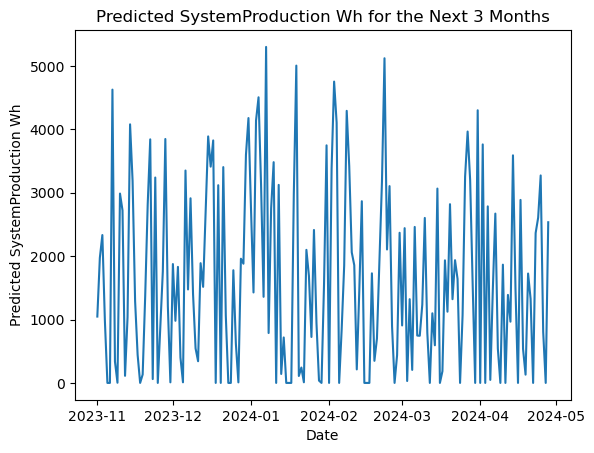

MSE: 225272.0182515291
R2: 0.07999843876419221


In [41]:
# Question 4
# Model to predict revenue model based on radiation, relativehumidity, and cloud coverage to solarproduction during 
# the day that shows how much power will be produced 1 week, 1 month, and 3 months out and if the system was effecient.
#

# Filter for daytime data
df_daytime = df_everythingbut_windair[df_everythingbut_windair['Is_Daytime'] == 1]

# Feature and target variables
X = df_daytime[['Radiation W/sqm', 'RelativeAirHumidity %', 'Cloud Coverage Minutes']]
y = df_daytime['SystemProduction Wh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Generate synthetic future data (e.g., for the next 90 days)
future_X = np.random.randn(180, 3)  # 180 days, 3 features
future_X = future_X * np.std(X_train, 0).values + np.mean(X_train, 0).values

# Predict future SystemProduction Wh
future_predictions = rf_model.predict(future_X)

# Plot future predictions
plt.plot(pd.date_range(start='2023-11-01', periods=180, freq='D'), future_predictions)
plt.xlabel('Date')
plt.ylabel('Predicted SystemProduction Wh')
plt.title('Predicted SystemProduction Wh for the Next 3 Months')
plt.show()

# Evaluate the model on the test set
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R2:", r2)